In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
!pip install -U ultralytics opencv-python

In [87]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import math
from ultralytics import YOLO
from IPython.display import Video, display


In [88]:
INPUT_VIDEO = "/content/drive/MyDrive/cctv.mp4/3603382381-preview.mp4"
OUTPUT_PATH = "/content/output_tracking_yolo11.mp4"
COMPRESSED_PATH = "/content/output_tracking_yolo11_compressed.mp4"

In [89]:
model = YOLO("yolo11n.pt")  # Latest YOLO-11 Nano

In [90]:
cap = cv2.VideoCapture(INPUT_VIDEO)

if not cap.isOpened():
    raise IOError("Error opening video file")

fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
TARGET_WIDTH, TARGET_HEIGHT = 640, 360

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (TARGET_WIDTH, TARGET_HEIGHT))

# Tracking / counting state
unique_person_ids = set()
entered_count = 0
exited_count = 0
frame_idx = 0
positions_history = defaultdict(list)  # id -> list of (frame_idx, (x,y))
last_seen = {}
in_frame = set()
movement_per_second = defaultdict(float)
missing_threshold_frames = int(fps * 1.5)  # treat missing > ~1.5s as exit

print("Processing video with YOLO-11...")

Processing video with YOLO-11...


In [91]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    frame = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT))

    results = model.track(
        frame,
        persist=True,
        classes=0,           # Person class
        tracker="bytetrack.yaml",
        verbose=False
    )

    result = results[0]

    current_ids = set()
    if getattr(result, 'boxes', None) is not None and result.boxes.id is not None:
        boxes = result.boxes.xyxy.cpu().numpy()
        ids = result.boxes.id.cpu().numpy()

        for box, track_id in zip(boxes, ids):
            tid = int(track_id)
            unique_person_ids.add(tid)
            x1, y1, x2, y2 = map(int, box)
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)

            positions_history[tid].append((frame_idx, (cx, cy)))

            # movement magnitude added to per-second bucket
            if len(positions_history[tid]) >= 2:
                _, (px, py) = positions_history[tid][-2]
                dist = math.hypot(cx - px, cy - py)
                sec = frame_idx // fps
                movement_per_second[sec] += dist

            last_seen[tid] = frame_idx
            current_ids.add(tid)

            # Entry detection: first time seen or re-appeared after exit
            if tid not in in_frame:
                entered_count += 1
                in_frame.add(tid)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                frame,
                f"ID: {tid}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2
            )

    # Exit detection: if an ID hasn't been seen for > missing_threshold_frames, consider exited
    for tid in list(in_frame):
        if last_seen.get(tid, 0) < frame_idx - missing_threshold_frames:
            exited_count += 1
            in_frame.remove(tid)

    cv2.putText(
        frame,
        f"Entered: {entered_count}  Exited: {exited_count}  Current: {len(in_frame)}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 0, 255),
        2
    )

    out.write(frame)

cap.release()
out.release()

print("Processing complete!")

Processing complete!


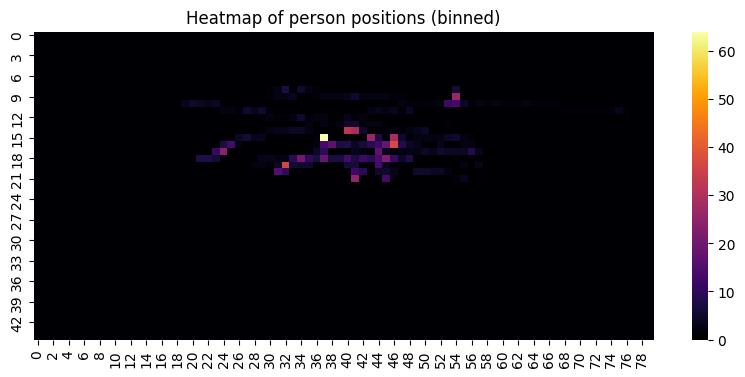

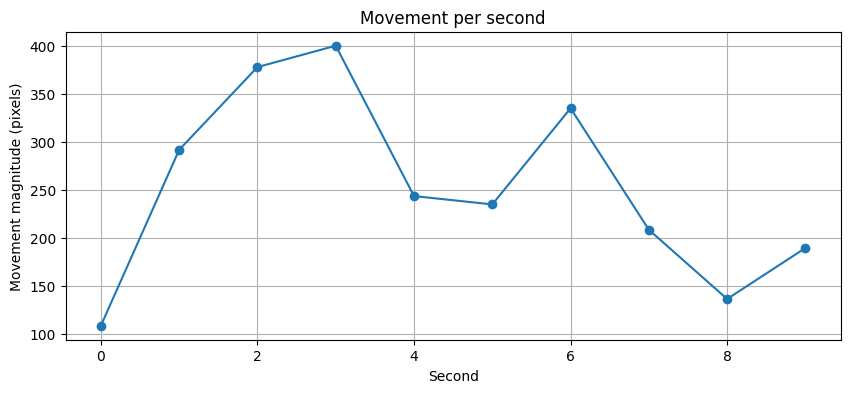

Unique IDs seen: 32 | Entered: 32 | Exited: 25 | Currently in frame: 7


In [92]:
all_centers = []
for pts in positions_history.values():
    for f, (x, y) in pts:
        all_centers.append((x, y))

if len(all_centers) > 0:
    xs = [c[0] for c in all_centers]
    ys = [c[1] for c in all_centers]
    # bin by a coarse grid
    heatmap, xedges, yedges = np.histogram2d(ys, xs, bins=(TARGET_HEIGHT//8, TARGET_WIDTH//8), range=[[0, TARGET_HEIGHT], [0, TARGET_WIDTH]])
    heatmap = np.flipud(heatmap)
    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap, cmap='inferno')
    plt.title('Heatmap of person positions (binned)')
    plt.show()
else:
    print("No position data collected for heatmap.")

# Movement per second plot
if len(movement_per_second) > 0:
    secs = sorted(movement_per_second.keys())
    vals = [movement_per_second[s] for s in secs]
    plt.figure(figsize=(10,4))
    plt.plot(secs, vals, marker='o')
    plt.xlabel('Second')
    plt.ylabel('Movement magnitude (pixels)')
    plt.title('Movement per second')
    plt.grid(True)
    plt.show()
else:
    print("No movement data recorded.")

# Summary counts
print(f"Unique IDs seen: {len(unique_person_ids)} | Entered: {entered_count} | Exited: {exited_count} | Currently in frame: {len(in_frame)}")

In [93]:
if os.path.exists(OUTPUT_PATH):
    os.system(f"ffmpeg -y -i {OUTPUT_PATH} -vcodec libx264 {COMPRESSED_PATH}")
    display(Video(COMPRESSED_PATH, embed=True, width=640))
else:
    print("Error: Output file not found")

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the entry_exit dictionary to a DataFrame
entry_exit_df = pd.DataFrame.from_dict(entry_exit, orient='index')
entry_exit_df.index.name = 'track_id'
entry_exit_df = entry_exit_df.reset_index()

# Display the DataFrame to see the structure
display(entry_exit_df.head())

,track_id,entry_time,exit_time,duration
0,4,0.166667,0.166667,0.0


Heatmap


In [78]:
print("Inspecting the 'tracks' dictionary:")
for track_id, points in tracks.items():
    print(f"Track ID: {track_id}, Number of points: {len(points)}")
    if len(points) > 0:
        print(f"  First point: {points[0]}")
    if len(points) > 1:
        print(f"  Last point: {points[-1]}")
print(f"\nTotal unique track IDs in 'tracks': {len(tracks)}")

Inspecting the 'tracks' dictionary:
Track ID: 4, Number of points: 1
  First point: {'frame': 0, 'time': 0.16666666666666666, 'x': 34, 'y': 714}

Total unique track IDs in 'tracks': 1
